In [1]:
# implement a copy number alteration (CNA) caller

In [2]:
# 0. Setup the libraries and input data

# 0.2 Load libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statistics

In [3]:
# 0.3 Load the input data
LogRatios = pd.read_csv('/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw8/log2ratios_chr1.txt', sep='\t')
x = LogRatios['log2Ratio'].values
copyNumberStates = np.array([1,2,3,4,5])
K = len(copyNumberStates)

In [4]:
# 0.4. Initialize model parameters and hyperparameters
pi_init = np.array([0.1,0.6,0.1,0.1,0.1]) 
mu_init = np.log2(copyNumberStates/2) 
var_init = np.array([statistics.variance(x) for m in range(K)]) 

A_init = np.zeros([K,K]) 
for i in range(K):
    A_init[i,] = (1-0.99999)/(K-1)
    A_init[i,i] = 0.99999
    
deltaPi_hyper = [2,6,2,2,2]

betaVar_hyper = np.array([1,1,1,1,1])
alphaVar_hyper = betaVar_hyper/(statistics.variance(x)/np.sqrt(K))

dirCounts = 100000
deltaA_hyper = A_init * dirCounts

In [5]:
# 1. Compute the Gaussian Emission Probabilities
from scipy.stats import norm
# 1.1. Define a function to compute the likelihood probabilities:
def compute_gauss_lik(x, mu, var):
    return np.array([norm.pdf(x, loc=m, scale=np.sqrt(v)) for m, v in zip(mu, var)])

In [6]:
# 1.2. Compute the Gaussian likelihood
gauss_lik = compute_gauss_lik(x, mu_init, var_init)
gauss_lik.shape

(5, 411)

In [7]:
def forward_backward(pi, A, obs_lik):
    
    # initialize
    Q,T = obs_lik.shape 
    scale = np.ones(T)
    alpha = np.zeros([Q,T])

    alpha[:,0] = obs_lik[:,0]*pi 

    scale[0] = sum(alpha[:,0])
    alpha[:,0]=alpha[:,0]/scale[0]

    # forward
    for t in range(1,len(obs_lik.T)):
        m = np.matmul(A.T,alpha[:,t-1])

        alpha[:,t] = m * obs_lik[:,t]

        scale[t] = sum(alpha[:,t]) 
        alpha[:,t]=alpha[:,t]/scale[t]

    loglik = sum(np.log(scale))

    # backward
    beta = np.zeros([Q,T])
    beta[:,T-1] = np.ones(Q)

    rho = np.zeros([Q,T])
    rho[:,T-1] = alpha[:,T-1]

    xi   = np.zeros([Q,Q,T])

    for t in reversed(range(0,T-1)):
        b = beta[:,t+1] * obs_lik[:,t+1]

        beta[:,t]=np.matmul(A,b)
        beta[:,t]=beta[:,t]/sum(beta[:,t])

        rho[:,t] = alpha[:,t] * beta[:,t]
        rho[:,t]=rho[:,t]/sum(rho[:,t])

        xi[:,:,t]= A * np.matmul(alpha[:,t].reshape(-1,1), b.reshape(-1,1).T) 

        xi[:,:,t] = xi[:,:,t]/sum(sum(xi[:,:,t]))

    return (rho,xi,loglik)

In [8]:
# 2.1. Compute the responsibilities in the E-Step
rho, xi, loglik = forward_backward(pi_init, A_init, gauss_lik)

In [9]:
# 2.2. Updating the initial state distribution parameter pi1:K in the M-Step 
    
# 2.2.1. Write a function to update the initial state distribution parameter
def update_pi(r, dp):
    pi_hat = np.zeros(K)
    for k in range(K):
        pi_hat[k] = (r[k, 0] + dp[k] - 1) / np.sum(r[:, 0] + dp - 1)
    return pi_hat

In [10]:
# 2.2.2. Compute pi_hat for the first iteration of EM
pi_hat = update_pi(rho, deltaPi_hyper)
pi_hat

array([0.1       , 0.59999995, 0.10000004, 0.10000001, 0.1       ])

In [11]:
# 2.3. Updating the Gaussian mean parameter mu_1:K in the M-Step 

# 2.3.1. Write a function to update Gaussian mean parameter
def update_mu(r, m, s):
    numerator = s * np.array([np.sum(np.matmul(r[k], x)) + m[k]*s[k] for k in range(K)])
    denominator = s * np.array([sum(r[k]) + s[k] for k in range(K)])
    return  numerator/denominator

In [12]:
# 2.3.2. Compute mu_hat for the first iteration of EM
mu_hat = update_mu(rho, mu_init, var_init)
mu_hat

array([-0.73897431, -0.06455449,  0.41025507,  0.99997391,  1.32192462])

In [13]:
# 2.4. Updating the Gaussian variance parameter in the M-Step

# 2.4.1. Write a function to update Gaussian variance parameter
def update_var(r, av, bv):
    var_hat = np.zeros(K)
    for k in range(K):
        x_mean = np.sum(r[k] * x) / np.sum(r[k])
        numerator = np.sum(r[k] * (x - x_mean)**2) + 2 * bv[k]
        denominator = np.sum(r[k]) + 2 * (av[k] + 1)
        var_hat[k] = numerator / denominator
    return var_hat

In [14]:
# 2.4.2. Compute the updated variance (var_hat) for the first iteration of EM
var_hat = update_var(rho, alphaVar_hyper, betaVar_hyper)
var_hat

array([0.065423  , 0.02591266, 0.04337017, 0.09182823, 0.09182825])

In [15]:
# 2.5. Updating the transition probabilities A in the M-Step 

# 2.5.1. Write a function to update the transition probabilities
def update_A(xi, da):
    A_hat = np.zeros((xi.shape[0], xi.shape[0]))
    for t in range(xi.shape[-1]-1):
        A_hat += xi[:, :, t]
    A_hat += da
    A_hat /= np.sum(A_hat, axis=1, keepdims=True)
    return A_hat

In [16]:
# 2.5.2. Compute A_hat for the first iteration of EM
A_hat = update_A(xi, deltaA_hyper)
A_hat

array([[9.99980017e-01, 3.79099447e-06, 1.11962291e-05, 2.49788535e-06,
        2.49787298e-06],
       [1.24825165e-05, 9.99978736e-01, 3.78888223e-06, 2.49648798e-06,
        2.49648435e-06],
       [1.24769357e-05, 2.49552280e-06, 9.99980037e-01, 2.49543219e-06,
        2.49541377e-06],
       [2.50002212e-06, 2.50000109e-06, 2.50001795e-06, 9.99990000e-01,
        2.50000000e-06],
       [2.50000292e-06, 2.50000020e-06, 2.50000294e-06, 2.50000000e-06,
        9.99990000e-01]])

In [17]:
# 2.6. Compute the log posterior
# 2.6.1. Write a function, compute_log_posterior, to compute the log posterior distribution
from scipy.stats import dirichlet, norm, invgamma
def compute_log_posterior(loglik, pi_hat, mu_hat, var_hat, A_hat):

    # log prior for pi
    dirichlet_prior = dirichlet.logpdf(pi_hat, deltaPi_hyper)

    # log prior for mu
    mu_prior = np.sum(norm.logpdf(mu_hat, loc=mu_init, scale=var_init))

    # log prior for variance sigma
    var_prior = np.sum(invgamma.logpdf(var_hat**2, a=alphaVar_hyper, scale=betaVar_hyper))

    # log prior for transition probabilities A
    dirichlet_prior_A = np.sum([dirichlet.logpdf(A_hat[k], deltaA_hyper[k]) for k in range(K)])

    # log posterior
    log_posterior = loglik + dirichlet_prior + mu_prior + var_prior + dirichlet_prior_A

    return log_posterior

In [18]:
# 2.6.2. Compute the log posterior for the input data
log_posterior = compute_log_posterior(loglik, pi_hat, mu_hat, var_hat, A_hat)
log_posterior

-2190.681466379619

In [19]:
# 3. Learn the HMM Parameters and Predict the Copy Number Segments
def iterate(mu, var, pi, A):

    # E-step
    gauss_lik = compute_gauss_lik(x, mu, var)
    rho, xi, loglik = forward_backward(pi, A, gauss_lik)
    
    # M-step
    pi_hat = update_pi(rho, deltaPi_hyper)
    mu_hat = update_mu(rho, mu, var)
    var_hat = update_var(rho, alphaVar_hyper, betaVar_hyper)
    A_hat = update_A(xi, deltaA_hyper)
    
    # log posterior
    log_posterior = compute_log_posterior(loglik, pi_hat, mu_hat, var_hat, A_hat)
    
    return (mu_hat, var_hat, pi_hat, A_hat, gauss_lik, log_posterior)

mu, var, pi, A = mu_init, var_init, pi_init, A_init
last_log_posterior, log_posterior = np.inf, -np.inf
while abs(last_log_posterior - log_posterior) > 0.0001:
    last_log_posterior = log_posterior
    mu, var, pi, A, obs_lik, log_posterior = iterate(mu, var, pi, A)
    print(log_posterior)

-2190.681466379619
-2607.4383601003888
-2639.939551931819
-2664.1606563970795
-2743.62071066921
-2846.4154281382566
-3004.319612749681
-3041.745212812041
-3046.999283635826
-3048.373501270937
-3048.725995989308
-3048.8181709569863
-3048.842754752952
-3048.849446589224
-3048.8513225023594
-3048.8518851806584
-3048.8520873773523
-3048.8521915849265
-3048.8522709134004


In [20]:
print("mu_hat: ", mu_init)
print("var_hat: ", var_init)
print("pi_hat: ", pi_init)
print("A_hat: ", A_init)

mu_hat:  [-1.          0.          0.5849625   1.          1.32192809]
var_hat:  [0.22609624 0.22609624 0.22609624 0.22609624 0.22609624]
pi_hat:  [0.1 0.6 0.1 0.1 0.1]
A_hat:  [[9.9999e-01 2.5000e-06 2.5000e-06 2.5000e-06 2.5000e-06]
 [2.5000e-06 9.9999e-01 2.5000e-06 2.5000e-06 2.5000e-06]
 [2.5000e-06 2.5000e-06 9.9999e-01 2.5000e-06 2.5000e-06]
 [2.5000e-06 2.5000e-06 2.5000e-06 9.9999e-01 2.5000e-06]
 [2.5000e-06 2.5000e-06 2.5000e-06 2.5000e-06 9.9999e-01]]


In [21]:
print(obs_lik.shape)

(5, 411)


In [22]:
def viterbi(log_pi, log_A, log_obs_lik):
    Q,T = log_obs_lik.shape
    
    delta = np.zeros([Q,T])
    psi = np.zeros([Q,T])
    path = np.zeros(T)

    delta[:,0] = log_pi + log_obs_lik[:,0] 
    
    psi[:,0] = 0
    
    # forward
    for t in range(1,T): 
        for j in range(0,Q):
            
            delta[j,t] = np.max(delta[:,t-1] + log_A[:,j])
            
            psi[j,t] = np.argmax(delta[:,t-1] + log_A[:,j])
            
            delta[j,t] = delta[j,t] + log_obs_lik[j,t]

    path = delta.argmax(axis=0)

    # backwards
    for t in reversed(range(0,T-1)): 
        path[t] = psi[path[t+1],t+1]         

    return(path)

In [23]:
# 3.2. Determine the copy number segments using the Viterbi algorithm
path = viterbi(np.log(pi_init), np.log(A_init), np.log(obs_lik))
print(path)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 2 2 2 2 2 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [24]:
# 4.1. Implement the function to calculate power
import scipy
def computePower(depth, alpha, M=1, c=2): # multiplicity = 1, copy number = 2
    mu = (alpha * M) / (alpha * c + 2 * (1 - alpha))
    return scipy.stats.binomtest(3, n=depth, p=mu, alternative='greater').pvalue # power to detect >=3 variant reads

In [25]:
# 4.2. What is the power for depth N=40 and tumor fraction alpha=0.2
computePower(depth=40, alpha=0.2)

0.7771918756605969

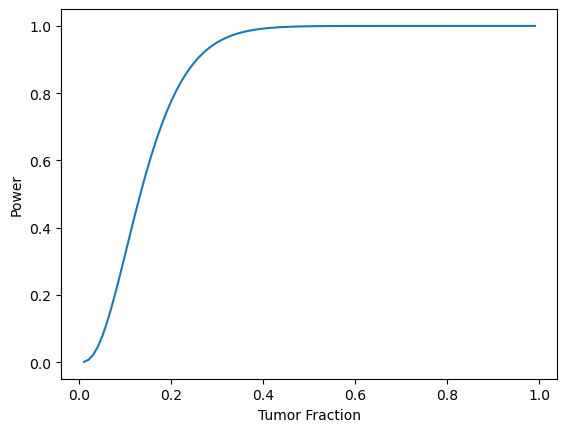

In [26]:
# 4.3. Plot a graph of the power estimates (y-axis) for a range of tumor fractions (x-axis)
plt.plot(np.arange(0.01, 1, 0.01), [computePower(depth=40, alpha=a) for a in np.arange(0.01, 1, 0.01)])
plt.xlabel("Tumor Fraction")
plt.ylabel("Power")
plt.show()

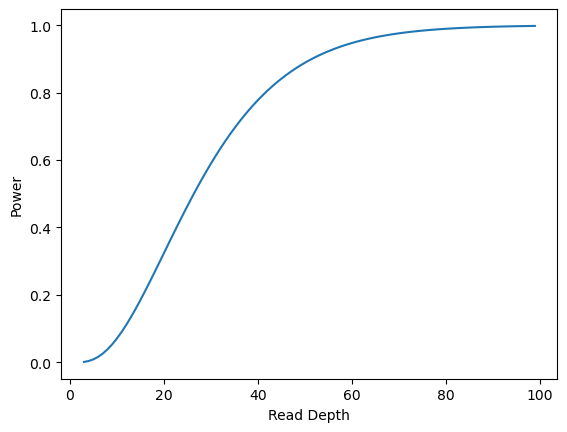

In [27]:
# 4.4. Plot a graph of the power (y-axis) required for a range of read depths (x-axis)
plt.plot(np.arange(3, 100, 1), [computePower(depth=d, alpha=0.2) for d in np.arange(3, 100, 1)])
plt.xlabel("Read Depth")
plt.ylabel("Power")
plt.show()

In [28]:
# 4.5. What is the minimum depth required for tumor fraction alpha=0.1 and desired power>=0.8?
print("Minimum Depth:", np.arange(3, 100, 1)[np.array([computePower(depth=d, alpha=0.1) for d in np.arange(3, 100, 1)]) >= 0.8][0])

Minimum Depth: 85
